In [37]:
import numpy as np 
import pandas as pd 
import sklearn as sk 
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Chargement des données 

In [38]:
#data = pd.read_csv('full_set_complete.csv').drop(columns=['Index'])
data = pd.read_csv('data_with_estimated_target.csv').drop(columns=['Unnamed: 0'])
Y_train= pd.read_csv('y_train_lXj6X5y.csv',index_col=0)
X_train= pd.read_csv('X_train_6ZIKlTY.csv', index_col=0)
X_test= pd.read_csv('X_test_oiZ2ukx.csv',index_col=0)
X_test.index = X_test.index + X_train.shape[0]  # Décale les index de X_test
data.head(3)

,patient_id,cohort,sexM,gene,age_at_diagnosis,age,ledd,time_since_intake_on,time_since_intake_off,on,off,on_off_ratio,off_cumavg,on_cumavg,off_lag1,on_lag1,off_ewma,index_measure,estimated_target
0,3332,0,0,1,48.5,52.1,607.0,1.9,14.779859,7.0,38.620296,0.176677,38.620296,7.000000,30.000000,13.0,38.620296,1,117.99196
1,3332,0,0,1,48.5,53.0,666.0,1.9,17.600000,12.0,44.000000,0.266667,41.310148,9.500000,38.620296,7.0,42.206765,2,143.79231
2,3332,0,0,1,48.5,53.9,717.0,1.2,14.878010,6.0,39.662327,0.147557,40.760874,8.333333,44.000000,12.0,40.510473,3,143.66864


## Feature engineering

In [39]:
fixed_features = ['cohort', 'sexM', 'gene', 'age_at_diagnosis']
temp_features = ['age', 'ledd', 'time_since_intake_on', 'time_since_intake_off', 'on', 'off', 'on_off_ratio', 
                 'off_cumavg', 'on_cumavg', 'off_lag1', 'on_lag1', 'off_ewma'] #, 'index_measure'
features = fixed_features + temp_features

# Normalisation des variables temporelles
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
data.head(2)


'''# Catégorisation en entiers
cat_features = ['cohort', 'sexM', 'gene']

# Pairwise interactions categorielles
for f1, f2 in combinations(cat_features, 2):
    data[f"{f1}_{f2}_interaction"] = data[f1] * 10 + data[f2]  # ou data[f1].astype(str) + "_" + data[f2].astype(str)'''

X_train_filled = data.loc[X_train.index]
Y_train = Y_train

#X_train_train, X_valid, y_train_train, y_valid = train_test_split(X_train_filled, Y_train, test_size=0.2, random_state=42)

#X_train_train.head(3)

In [40]:
def split_by_patient(X, y, patient_id_column='patient_id', test_size=0.2, random_state=42):

    # Extract the unique patient IDs
    unique_patients = X[patient_id_column].unique()
    
    np.random.seed(random_state)
    np.random.shuffle(unique_patients)
    
    # Calculate the split index based on the test size
    split_idx = int((1 - test_size) * len(unique_patients))
    
    # Split the patients into train and validation sets
    train_patients = unique_patients[:split_idx]
    valid_patients = unique_patients[split_idx:]
    
    # Split the data using the patient IDs
    X_train = X[X[patient_id_column].isin(train_patients)]
    X_valid = X[X[patient_id_column].isin(valid_patients)]
    y_train = y[X[patient_id_column].isin(train_patients)]
    y_valid = y[X[patient_id_column].isin(valid_patients)]
    
    return X_train, X_valid, y_train, y_valid

X_train_train, X_valid, y_train_train, y_valid = split_by_patient(X_train_filled, Y_train, test_size=0.2, random_state=42)


In [42]:
# Avec RF

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_train, y_train_train)


y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
print(f"Mean Squared Error sur le set de validation : {mse}")

c:\Users\soelm\Documents\04_Code\MVA\MVA_venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error sur le set de validation : 21.687709964172623


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# --- Initialisation du modèle LightGBM ---
model = lgb.LGBMRegressor(random_state=42)

# --- Définir la grille des hyperparamètres à tester ---
param_grid = {
    'n_estimators': [80],          # Nombre d'arbres
    'learning_rate': [0.1],      # Taux d'apprentissage
    'num_leaves': [120],             # Nombre de feuilles dans l'arbre
    'max_depth': [10],                # Profondeur maximale des arbres
    'subsample': [0.8],                 # Fraction de données utilisées pour chaque arbre
    'colsample_bytree': [0.8] #, 1.0]           # Fraction des features à utiliser par arbre
}

# --- GridSearchCV ---
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=4,                             # Validation croisée avec 5 folds
                           scoring='neg_mean_squared_error',  # Critère à minimiser : l'erreur quadratique
                           n_jobs=-1,                         # Utiliser tous les cœurs pour accélérer le calcul
                           verbose=1)                         # Afficher des informations pendant l'exécution

# --- Entraînement de la recherche d'hyperparamètres ---
grid_search.fit(X_train_train, y_train_train)

# --- Meilleurs hyperparamètres trouvés ---
print(f"Meilleurs paramètres trouvés : {grid_search.best_params_}")

# --- Utilisation du meilleur modèle pour prédiction ---
best_model = grid_search.best_estimator_

# Prédiction sur le set de validation
y_pred = best_model.predict(X_valid)

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_valid, y_pred)
print(f"Mean Squared Error après GridSearch : {mse}")


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3846
[LightGBM] [Info] Number of data points in the train set: 44550, number of used features: 19
[LightGBM] [Info] Start training from score 37.213183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80, 'num_leaves': 120, 'subsample': 0.8}
Mean Squared Error après GridSearch : 20.820125893326946


In [41]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# --- Initialisation du modèle LightGBM ---
model = lgb.LGBMRegressor(n_estimators=80, num_leaves=120, subsample=0.8, learning_rate=0.1, max_depth=10, colsample_bytree=0.8, random_state=42)

# Entraînement du modèle
model.fit(X_train_train, y_train_train)

# Prédiction sur le set de validation
y_pred = model.predict(X_valid)

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_valid, y_pred)
print(f"Mean Squared Error sur le set de validation : {mse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3846
[LightGBM] [Info] Number of data points in the train set: 44550, number of used features: 19
[LightGBM] [Info] Start training from score 37.213183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Mean Squared Error sur le set de validation : 20.9641821859832


C:\Users\soelm\AppData\Local\Temp\ipykernel_27644\701310133.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')


Text(0, 0.5, 'Features')

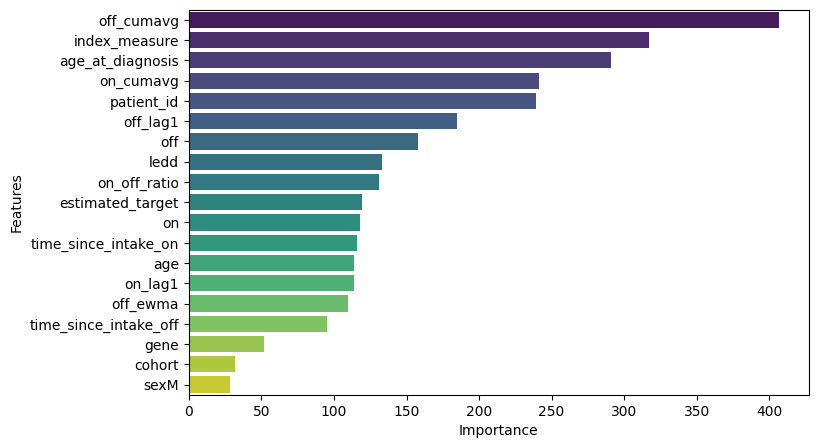

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire l'importance des features
feature_importance = model.feature_importances_

# Créer un DataFrame pour trier et visualiser
importance_df = pd.DataFrame({'Feature': X_train_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les valeurs
#print(importance_df)

# Visualisation avec un barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Features')


## Soumission finale

In [44]:
X_train_filled

,patient_id,cohort,sexM,gene,age_at_diagnosis,age,ledd,time_since_intake_on,time_since_intake_off,on,off,on_off_ratio,off_cumavg,on_cumavg,off_lag1,on_lag1,off_ewma,index_measure,estimated_target
Index,,,,,,,,,,,,,,,,,,,
0,3332,-0.349128,-1.230396,-0.579843,-0.758273,-0.899541,0.077090,-0.033392,0.503441,-1.173437,0.520783,-0.470384,0.854610,-1.186945,0.035112,-0.559846,0.589245,1,117.99196
1,3332,-0.349128,-1.230396,-0.579843,-0.758273,-0.820878,0.362618,-0.033392,2.604987,-0.694445,0.859732,-0.408921,1.046644,-0.892206,0.583761,-1.143164,0.824572,2,143.79231
2,3332,-0.349128,-1.230396,-0.579843,-0.758273,-0.742215,0.609431,-0.820179,0.576582,-1.269235,0.586436,-0.490273,1.007430,-1.029751,0.926159,-0.657065,0.713269,3,143.66864
3,3332,-0.349128,-1.230396,-0.579843,-0.758273,-0.663552,0.865923,-0.482985,0.464300,-0.790243,0.619263,-0.408626,0.997123,-0.951154,0.650082,-1.240383,0.698960,4,143.68024
4,3332,-0.349128,-1.230396,-0.579843,-0.758273,-0.480004,1.422461,-1.831762,0.164487,0.455136,0.695859,-0.204442,1.008296,-0.597466,0.683243,-0.754285,0.747369,5,143.63799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55598,1159,-0.349128,0.812747,-0.579843,0.224954,-0.156612,-0.516453,-0.673415,-0.478787,-0.539185,-1.849493,4.060417,-1.831179,-0.411166,-1.810626,-0.507374,-1.879230,2,165.95380
55599,1159,-0.349128,0.812747,-0.579843,0.224954,-0.112910,-0.300020,-0.588765,-0.417279,-0.502163,-1.660477,1.322325,-1.759787,-0.394388,-1.810626,-0.499502,-1.747999,3,166.15166
55600,1159,-0.349128,0.812747,-0.579843,0.224954,-0.051728,-0.279769,-0.712615,-0.492315,-0.524886,-1.912498,8.813833,-1.795483,-0.392990,-1.619687,-0.461931,-1.879230,4,166.42227


In [46]:
X_train_filled, Y_train

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# --- Initialisation du modèle LightGBM ---
model = lgb.LGBMRegressor(n_estimators=80, num_leaves=120, subsample=0.8, learning_rate=0.1, max_depth=10, colsample_bytree=0.8, random_state=42)

# Entraînement du modèle
model.fit(X_train_filled, Y_train)

X_test_filled = data.loc[X_test.index]
# Prédiction sur le set de validation
y_pred = model.predict(X_test_filled)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3847
[LightGBM] [Info] Number of data points in the train set: 55603, number of used features: 19
[LightGBM] [Info] Start training from score 37.331606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [48]:
results = pd.DataFrame({
    'target': y_pred  # Prédictions du modèle
})

# Réinitialisez l'index pour qu'il commence de 0, 1, 2, etc.
results.reset_index(drop=True, inplace=True)

# Enregistrez le DataFrame en fichier CSV sans index
results.to_csv('predictions.csv', index_label='Index')  # 'Index' sera utilisé comme nom de colonne